# Project 4 : Kaggle West Nile Virus

----------

## Contents:
### Part 2 Feature Engineering & Modelling

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Importing Data](#2.-Importing-Data)
3. [Feature Engineering](#3.-Feature-Engineering)
4. [Model Preparation](#4.-Model-Preparation)
5. [Model Production & Kaggle Submission](#5.-Model-Production-&-Kaggle-Submission)
-------

## 1. Importing Libraries

In [83]:
#run if required
#pip install xgboost
#pip install imblearn

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import math
import pickle
from prettytable import PrettyTable
# Display full output 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

## 2. Importing Data

In [4]:
combine_train = pd.read_pickle('./data/combine_train.pk1')
combine_test = pd.read_pickle('./data/combine_test.pk1')
test_id = pd.read_pickle('./data/test_id.pk1')
weather = pd.read_pickle('./data/weather.pk1')

In [5]:
combine_train.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,wnvpresent,nummosquitos,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist
0,2007-05-29,CULEX PIPIENS,22,W 89TH ST,T096,41.731922,-87.677512,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,N STAVE ST,T050,41.919343,-87.694259,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,N CANNON DR,T054,41.921965,-87.632085,8,0,2,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,41.688324,-87.676709,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0


## 3. Feature Engineering

<b>Train Data</b>:
- Dropped nummosquitos variable due to not available in test data
- Assigning weight to the species variable: pipiens & pipiens_restuans = 2, restuans = 1 and other species = 0
- Created an interaction column between sunset and sunrise called nighttime
- Converted categorical variable into dummy variables
- Created three new features using Polynomial Feature Engineering

<b>Test Data</b>:
- Assigning weight to the species variable: pipiens & pipiens_restuans = 2, restuans = 1 and other species = 0
- Created an interaction column between sunset and sunrise called nighttime
- Converted categorical variable into dummy variables
- Created three new features

### 3.1 Train Data

In [6]:
combine_train.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,wnvpresent,nummosquitos,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist
0,2007-05-29,CULEX PIPIENS,22,W 89TH ST,T096,41.731922,-87.677512,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,N STAVE ST,T050,41.919343,-87.694259,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,N CANNON DR,T054,41.921965,-87.632085,8,0,2,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,41.688324,-87.676709,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0


#### a) Dropped nummosquitos variable due to not available in test data

In [7]:
combine_train.drop(columns = ['nummosquitos'], axis = 1, inplace = True)

In [8]:
combine_train.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,wnvpresent,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist
0,2007-05-29,CULEX PIPIENS,22,W 89TH ST,T096,41.731922,-87.677512,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,N STAVE ST,T050,41.919343,-87.694259,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,N CANNON DR,T054,41.921965,-87.632085,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,41.688324,-87.676709,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0


#### b) Assigning weight to the species variable: pipiens & pipiens_restuans = 2, restuans = 1 and other species = 0

In [9]:
combine_train['species'] = combine_train['species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1}).fillna(0)

#### c) Created an interaction column between sunset and sunrise called nighttime

In [10]:
combine_train['nighttime'] = (24 - round((combine_train['sunset'] - combine_train['sunrise'])/100,0))

In [11]:
combine_train.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,wnvpresent,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist,nighttime
0,2007-05-29,2.0,22,W 89TH ST,T096,41.731922,-87.677512,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0,9.0
1,2007-05-29,2.0,11,W ROOSEVELT,T048,41.867108,-87.654224,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0,9.0
2,2007-05-29,2.0,21,N STAVE ST,T050,41.919343,-87.694259,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0,9.0
3,2007-05-29,2.0,22,N CANNON DR,T054,41.921965,-87.632085,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0,9.0
4,2007-05-29,2.0,22,W 113TH ST,T086,41.688324,-87.676709,8,0,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0,9.0


In [12]:
combine_train.drop(columns = ['sunrise', 'sunset'], axis = 1, inplace = True)

#### d) Converted categorical variable into dummy variables

In [13]:
cat_col = combine_train.dtypes[combine_train.dtypes == 'object'].index.tolist()
cat_col

['street', 'trap']

In [14]:
# Converting combine data categorical features to dummy feature using one-hot encoding

combine_train = pd.get_dummies(combine_train, columns = cat_col, drop_first = True)

In [15]:
combine_train.head()

,date,species,block,latitude,longitude,addressaccuracy,wnvpresent,year,month,day,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist,nighttime,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,street_ E 130TH ST,street_ E 138TH ST,street_ E 67TH ST,street_ E 91ST PL,street_ E 91ST ST,street_ E RANDOLPH ST,street_ N ASHLAND AVE,street_ N ASHLAND AVE OVERPASS,street_ N AUSTIN AVE,street_ N AVONDALE AVE,street_ N CALIFORNIA AVE,street_ N CAMPBELL AVE,street_ N CANNON DR,street_ N CENTRAL PARK DR,street_ N FRANCISCO AVE,street_ N HARLEM AVE,street_ N HUMBOLDT DR,street_ N KEDVALE AVE,street_ N LARAMIE AVE,street_ N LAWLER AVE,street_ N LEMONT AVE,street_ N LONG AVE,street_ N MANDELL AVE,street_ N MCCLELLAN AVE,street_ N MILWAUKEE AVE,street_ N MONT CLARE AVE,street_ N MOSELL AVE,street_ N OAK PARK AVE,street_ N OAKLEY AVE,street_ N OKETO AVE,street_ N PITTSBURGH AVE,street_ N PULASKI RD,street_ N RICHMOND ST,street_ N RIDGE AVE,street_ N RUTHERFORD AVE,street_ N SPRINGFIELD AVE,street_ N STAVE ST,street_ N STREETER DR,street_ N TRIPP AVE,street_ N WESTERN AVE,street_ S ARTESIAN AVE,street_ S ASHLAND AVE,street_ S AVENUE G,street_ S AVENUE L,street_ S BRANDON,street_ S CALIFORNIA,street_ S CALIFORNIA AVE,street_ S CARPENTER ST,street_ S CENTRAL AVE,street_ S CHICAGO AVE,street_ S CICERO AVE,street_ S CORNELL AVE,street_ S COTTAGE GROVE,street_ S DEARBORN ST,street_ S DOTY AVE,street_ S DR MARTIN LUTHER KING JR DR,street_ S EBERHART AVE,street_ S HAMLIN AVE,street_ S HOYNE AVE,street_ S KEDZIE AVE,street_ S KILPATRICK AVE,street_ S KOLMAR,street_ S KOSTNER AVE,street_ S LONGWOOD DR,street_ S MACKINAW,street_ S MELVINA AVE,street_ S MILLARD AVE,street_ S MUSKEGON AVE,street_ S NORDICA,street_ S PEORIA ST,street_ S PULASKI RD,street_ S RACINE AVE,street_ S SOUTH SHORE DR,street_ S STATE ST,street_ S STONY ISLAND AVE,street_ S THROOP,street_ S TORRENCE AVE,street_ S UNION AVE,street_ S VINCENNES,street_ S WALLACE ST,street_ S WESTERN AVE,street_ W 104TH ST,street_ W 113TH ST,street_ W 116TH ST,street_ W 127TH PL,street_ W 18TH ST,street_ W 31ST ST,street_ W 37TH PL.,street_ W 51ST ST,street_ W 63RD ST,street_ W 64TH ST,street_ W 65TH ST,street_ W 69TH ST,street_ W 72ND ST,street_ W 77TH ST,street_ W 85TH ST,street_ W 89TH ST,street_ W 95TH ST,street_ W ADDISON ST,street_ W AGATITE AVE,street_ W BALMORAL AVE,street_ W BELDEN AVE,street_ W CHICAGO,street_ W FARWELL AVE,street_ W FOSTER AVE,street_ W FULLERTON AVE,street_ W GARFIELD BLVD,street_ W GRAND AVE,street_ W GRANVILLE AVE,street_ W GREENLEAF AVE,street_ W HIGGINS AVE,street_ W HIGGINS RD,street_ W LELAND AVE,street_ W MONTANA ST,street_ W MONTROSE DR,street_ W OHARE,street_ W OHARE AIRPORT,street_ W PERSHING RD,street_ W ROOSEVELT,street_ W ROSCOE ST,street_ W STRONG ST,street_ W SUNNYSIDE AVE,street_ W WEBSTER AVE,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T20

In [16]:
combine_train.shape

(8610, 289)

#### e) Created three new features using Polynomial Feature Engineering

In [17]:
X = combine_train[[col for col in combine_train.columns if 'wnvpresent' not in col]]._get_numeric_data()
y = combine_train['wnvpresent']

In [18]:
# Generates the full polynomial feature table

poly = PolynomialFeatures(include_bias=False, degree=2)
X_poly = poly.fit_transform(X)
X_poly.shape

(8610, 41615)

In [19]:
# Adds appropriate feature names to all polynomial features
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names_out(X.columns))

# Generates list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

# Shows features most highly correlated (positively) with target
X_poly_corrs.sort_values(ascending=False).head(20)

month dewpoint        0.141432
month tmin            0.140573
month wetbulb         0.137780
species dewpoint      0.135395
tmin nighttime        0.134848
dewpoint nighttime    0.133661
wetbulb nighttime     0.132617
species tmin          0.131869
species wetbulb       0.130693
month tavg            0.129616
species month         0.128488
species tavg          0.125976
tavg nighttime        0.123590
species tmax          0.119860
species nighttime     0.119666
species cool          0.116523
month tmax            0.115279
species^2             0.108279
species latitude      0.106734
species year          0.106669
dtype: float64

In [20]:
# Creating interaction features -- only 3 due to multicollinearity issues

combine_train['month_dewpoint '] = combine_train['month'] * combine_train['dewpoint']
combine_train['species_dewpoint '] = combine_train['species'] * combine_train['dewpoint']
combine_train['nightime_dewpoint '] = combine_train['nighttime'] * combine_train['dewpoint']

In [21]:
cm = abs(combine_train.corr()['wnvpresent']).sort_values(ascending=False)


wnvpresent                               1.000000
month_dewpoint                           0.141432
species_dewpoint                         0.135395
nightime_dewpoint                        0.133661
species                                  0.106470
month                                    0.096551
dewpoint                                 0.092623
wetbulb                                  0.090795
tmin                                     0.086795
tavg                                     0.076406
nighttime                                0.074080
longitude                                0.074075
cool                                     0.073280
street_ W OHARE AIRPORT                  0.069653
trap_T900                                0.069653
depart                                   0.063704
tmax                                     0.058451
heat                                     0.056645
resultspeed                              0.051055
year                                     0.042496


In [22]:
# Variables with less than 2% correlation to wnvpresent

cols_to_drop = cm[cm < 0.02].index
cols_to_drop

Index(['street_ W 18TH ST', 'trap_T043', 'street_ W FOSTER AVE', 'trap_T015',
       'street_ N PITTSBURGH AVE', 'trap_T011', 'trap_T096',
       'street_ W 89TH ST', 'street_ W CHICAGO', 'trap_T049',
       ...
       'trap_T066', 'trap_T162', 'street_ S KILPATRICK AVE', 'trap_T156',
       'street_ W 127TH PL', 'trap_T135', 'street_ W GARFIELD BLVD',
       'trap_T226', 'street_ N HUMBOLDT DR', 'trap_T033'],
      dtype='object', length=232)

In [23]:
# Drop all the variables with less than 2% correlation to wnvpresent

combine_train = combine_train.drop(columns = cols_to_drop)
combine_train.shape

(8610, 60)

In [24]:
cm = abs(combine_train.corr()['wnvpresent']).sort_values(ascending=False)
cm = cm.drop('wnvpresent')
cols_to_keep = cm.head(40)
cols_to_keep

month_dewpoint              0.141432
species_dewpoint            0.135395
nightime_dewpoint           0.133661
species                     0.106470
month                       0.096551
dewpoint                    0.092623
wetbulb                     0.090795
tmin                        0.086795
tavg                        0.076406
nighttime                   0.074080
longitude                   0.074075
cool                        0.073280
trap_T900                   0.069653
street_ W OHARE AIRPORT     0.069653
depart                      0.063704
tmax                        0.058451
heat                        0.056645
resultspeed                 0.051055
year                        0.042496
street_ N OAK PARK AVE      0.038420
street_ N MILWAUKEE AVE     0.036029
trap_T003                   0.036029
avgspeed                    0.033341
trap_T225                   0.033060
street_ S KOSTNER AVE       0.033060
trap_T143                   0.031974
trap_T086                   0.030978
s

In [25]:
final_train_df = combine_train[cols_to_keep.keys()]

In [26]:
final_train_df.shape

(8610, 40)

### 3.2 Test Data

In [27]:
combine_test.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist
0,2008-06-11,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0
1,2008-06-11,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0
2,2008-06-11,CULEX PIPIENS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0
3,2008-06-11,CULEX SALINARIUS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0
4,2008-06-11,CULEX TERRITANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0


#### a) Assigning weight to the species variable: pipiens & pipiens_restuans = 2, restuans = 1 and other species = 0

In [28]:
combine_test['species'] = combine_test['species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1}).fillna(0)

#### b) Created an interaction column between sunset and sunrise called nighttime

In [29]:
combine_test['nighttime'] = (24 - round((combine_test['sunset'] - combine_test['sunrise'])/100,0))

In [30]:
combine_test.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist,nighttime
0,2008-06-11,2.0,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0,9.0
1,2008-06-11,1.0,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0,9.0
2,2008-06-11,2.0,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0,9.0
3,2008-06-11,0.0,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0,9.0
4,2008-06-11,0.0,41,N OAK PARK AVE,T002,41.95469,-87.800991,9,2008,6,11,416.0,1926.0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,0.0,0.0,9.0


In [31]:
combine_test.drop(columns = ['sunrise', 'sunset'], axis = 1, inplace = True)

#### c) Converted categorical variable into dummy variables

In [32]:
cat_col = combine_test.dtypes[combine_test.dtypes == 'object'].index.tolist()
cat_col

['street', 'trap']

In [33]:
# Converting combine data categorical features to dummy feature using one-hot encoding

combine_test = pd.get_dummies(combine_test, columns = cat_col, drop_first = True)

In [34]:
combine_test.head()

,date,species,block,latitude,longitude,addressaccuracy,year,month,day,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist,nighttime,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,street_ E 130TH ST,street_ E 136TH ST,street_ E 138TH ST,street_ E 67TH ST,street_ E 91ST PL,street_ E 91ST ST,street_ E RANDOLPH ST,street_ N ASHLAND AVE,street_ N ASHLAND AVE OVERPASS,street_ N AUSTIN AVE,street_ N AVONDALE AVE,street_ N CALIFORNIA AVE,street_ N CAMPBELL AVE,street_ N CANNON DR,street_ N CENTRAL PARK DR,street_ N FRANCISCO AVE,street_ N HARLEM AVE,street_ N HUMBOLDT DR,street_ N KEDVALE AVE,street_ N KENNETH AVE,street_ N KILBOURN AVE,street_ N LARAMIE AVE,street_ N LAWLER AVE,street_ N LEMONT AVE,street_ N LONG AVE,street_ N MANDELL AVE,street_ N MCCLELLAN AVE,street_ N MELVINA AVE,street_ N MILWAUKEE AVE,street_ N MONT CLARE AVE,street_ N MOSELL AVE,street_ N OAK PARK AVE,street_ N OAKLEY AVE,street_ N OKETO AVE,street_ N PITTSBURGH AVE,street_ N PULASKI RD,street_ N RICHMOND ST,street_ N RIDGE AVE,street_ N RUTHERFORD AVE,street_ N SPRINGFIELD AVE,street_ N STAVE ST,street_ N STREETER DR,street_ N TRIPP AVE,street_ N WESTERN AVE,street_ S ARTESIAN AVE,street_ S ASHLAND AVE,street_ S AVENUE G,street_ S AVENUE L,street_ S BALTIMORE AVE,street_ S BRANDON,street_ S CALIFORNIA,street_ S CALIFORNIA AVE,street_ S CARPENTER ST,street_ S CENTRAL AVE,street_ S CHICAGO AVE,street_ S CICERO AVE,street_ S CORNELL AVE,street_ S COTTAGE GROVE,street_ S DEARBORN ST,street_ S DOTY AVE,street_ S DR MARTIN LUTHER KING JR DR,street_ S EBERHART AVE,street_ S HAMLIN AVE,street_ S HOYNE AVE,street_ S KEDZIE AVE,street_ S KILPATRICK AVE,street_ S KOLMAR,street_ S KOSTNER AVE,street_ S LONGWOOD DR,street_ S LOOMIS ST,street_ S MACKINAW,street_ S MELVINA AVE,street_ S MILLARD AVE,street_ S MUSKEGON AVE,street_ S NORDICA,street_ S OGLESBY AVE,street_ S PEORIA ST,street_ S PULASKI RD,street_ S RACINE AVE,street_ S SOUTH SHORE DR,street_ S STATE ST,street_ S STONY ISLAND AVE,street_ S THROOP,street_ S TORRENCE AVE,street_ S UNION AVE,street_ S VINCENNES,street_ S WALLACE ST,street_ S WESTERN AVE,street_ W 104TH ST,street_ W 112TH ST,street_ W 113TH ST,street_ W 116TH ST,street_ W 120TH ST,street_ W 127TH PL,street_ W 18TH ST,street_ W 31ST ST,street_ W 37TH PL.,street_ W 51ST ST,street_ W 63RD PL,street_ W 63RD ST,street_ W 64TH ST,street_ W 65TH ST,street_ W 69TH ST,street_ W 72ND ST,street_ W 77TH ST,street_ W 85TH ST,street_ W 89TH ST,street_ W 95TH ST,street_ W ADDISON ST,street_ W AGATITE AVE,street_ W BALMORAL AVE,street_ W BELDEN AVE,street_ W CHICAGO,street_ W DAKIN ST,street_ W FARWELL AVE,street_ W FOSTER AVE,street_ W FULLERTON AVE,street_ W GARFIELD BLVD,street_ W GRAND AVE,street_ W GRANVILLE AVE,street_ W GREENLEAF AVE,street_ W HIGGINS AVE,street_ W HIGGINS RD,street_ W LELAND AVE,street_ W MONTANA ST,street_ W MONTROSE DR,street_ W OHARE,street_ W OHARE AIRPORT,street_ W PERSHING RD,street_ W ROOSEVELT,street_ W ROSCOE ST,street_ W STRONG ST,street_ W SUNNYSIDE AVE,street_ W WEBSTER AVE,trap_T002,trap_T002A,trap_T002B,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T065A,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T090A,trap_T090B,trap_T090C,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T

In [35]:
combine_test.shape

(116293, 312)

#### d) Created three new features

In [36]:
# Creating interaction features -- only 2 due to multicollinearity issues

combine_test['month_dewpoint '] = combine_test['month'] * combine_test['dewpoint']
combine_test['species_dewpoint '] = combine_test['species'] * combine_test['dewpoint']
combine_test['nightime_dewpoint '] = combine_test['nighttime'] * combine_test['dewpoint']

In [37]:
final_test_df = combine_test[cols_to_keep.keys()]

In [38]:
[col for col in final_test_df if col not in final_train_df], [col for col in final_train_df if col not in final_test_df]

([], [])

In [39]:
final_test_df.shape

(116293, 40)

## 4. Model Preparation

- <b>Train Test Split</b>

- <b>Define Function</b>

- <b>Modelling</b>

    - Logistic Regression
    - Random Forest Classifier
    - Extreme Gradient Boosting Classifier
    - AdaBoost Classifier
    - Plot AUC-ROC Curve   
    
    
- <b>Model Hyperparameter Tuning</b>

    - Model Hyperparameters
    - Logistic Regression
    - Random Forest Classifier
    - Extreme Gradient Boosting Classifier
    - AdaBoost Classifier
    - Plot AUC-ROC Curve

### 4.1 Train Test Split

In [40]:
# Create our feature matrix (X) and target vector (y)

X = final_train_df
y = combine_train['wnvpresent']

In [41]:
# export the training dataset for cost & benefit analysis later
final_train_df.to_pickle('./data/final_train.pk1')
# export the test dataset for cost & benefit analysis later
final_test_df.to_pickle('./data/final_test.pk1')

In [42]:
X.head()

,month_dewpoint,species_dewpoint,nightime_dewpoint,species,month,dewpoint,wetbulb,tmin,tavg,nighttime,longitude,cool,trap_T900,street_ W OHARE AIRPORT,depart,tmax,heat,resultspeed,year,street_ N OAK PARK AVE,street_ N MILWAUKEE AVE,trap_T003,avgspeed,trap_T225,street_ S KOSTNER AVE,trap_T143,trap_T086,street_ W 113TH ST,latitude,rain,trap_T002,trap_T223,street_ N MONT CLARE AVE,street_ N AVONDALE AVE,trap_T006,trap_T046,street_ W GRAND AVE,street_ S DOTY AVE,trap_T115,trap_T233
0,292.5,117.0,526.5,2.0,5,58.5,65.5,62.5,75.5,9.0,-87.677512,10.5,0,0,10.0,88.0,0.0,5.8,2007,0,0,0,6.95,0,0,0,0,0,41.731922,0.0,0,0,0,0,0,0,0,0,0,0
1,292.5,117.0,526.5,2.0,5,58.5,65.5,62.5,75.5,9.0,-87.654224,10.5,0,0,10.0,88.0,0.0,5.8,2007,0,0,0,6.95,0,0,0,0,0,41.867108,0.0,0,0,0,0,0,0,0,0,0,0
2,292.5,117.0,526.5,2.0,5,58.5,65.5,62.5,75.5,9.0,-87.694259,10.5,0,0,10.0,88.0,0.0,5.8,2007,0,0,0,6.95,0,0,0,0,0,41.919343,0.0,0,0,0,0,0,0,0,0,0,0
3,292.5,117.0,526.5,2.0,5,58.5,65.5,62.5,75.5,9.0,-87.632085,10.5,0,0,10.0,88.0,0.0,5.8,2007,0,0,0,6.95,0,0,0,0,0,41.921965,0.0,0,0,0,0,0,0,0,0,0,0
4,292.5,117.0,526.5,2.0,5,58.5,65.5,62.5,75.5,9.0,-87.676709,10.5,0,0,10.0,88.0,0.0,5.8,2007,0,0,0,6.95,0,0,0,1,1,41.688324,0.0,0,0,0,0,0,0,0,0,0,0


In [43]:
# Perform a split of our X and y 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [44]:
# Baseline 

y.value_counts(normalize=True)

0    0.946922
1    0.053078
Name: wnvpresent, dtype: float64

<b>Observation<b/> : 

1. The class is imbalance. Standard metrics such as accuracy can not be used to evaluate model performance. The dataset we're using is strongly biased towards samples where West Nile Virus is absent. In this case, assigning a post randomly will give us a 95% accuracy of classifying the West Nile Virus is absent correctly.
2. Thus, Area Under Curve (AUC) will be our main metrics here as it focuses on our sensitivity and specificity of our model. AUC measures how true positive rate (recall) and false positive rate trade off. This reveals how good a model is at distinguishing between positive class and negative class.
3. Also, given our imbalanced classes, we will use SMOTE which is an oversampling technique where the synthetic samples are generated for the minority class in order to attempts to balance class distribution.

In [45]:
# Instantiate SMOTE

smt = SMOTE()

X_train, y_train = smt.fit_resample(X_train, y_train)

In [46]:
# Check proportions after SMOTE

y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

### 4.2 Define Function

In [47]:
# Instiantiate models

models = {'lr': LogisticRegression(random_state=42, max_iter=5_000, solver = 'saga'),
          'rf': RandomForestClassifier(random_state=42),
          'xgb' : XGBClassifier(random_state=42, use_label_encoder = False, eval_metric='mlogloss'),
          'ada': AdaBoostClassifier(random_state=42)}

In [48]:
# Create a PrettyTable to store overall summary of model performance without hyperparameter tuning

summary = PrettyTable(['Model', 'Train AUC', 'Test AUC', 'Precision', 'Specificity', 'Recall', 'F1_score'])


# Create a PrettyTable to store overall summary of model performance with hyperparameter tuning

summary_tuning = PrettyTable(['Model', 'Train AUC', 'Test AUC', 'Precision', 'Specificity', 'Recall', 'F1_score'])

In [49]:
# Define a function to run model -- input vectorizer and model

def run_model(model, title, model_params = {}, grid_search = False):
        
    # Create a PrettyTable for individual model
    indv = PrettyTable(['Model', 'Train AUC', 'Test AUC', 'Precision', 'Specificity', 'Recall', 'F1_score'])
    
    # Set up pipeline with two stages: 
    # 1. Scale 
    # 2. Model 
    pipe = Pipeline([
                    ('ss', StandardScaler()),
                     (model, models[model])
                    ])
    
    if grid_search == True:
        model_gs = GridSearchCV(pipe, param_grid = model_params, cv = 10, verbose = 1, scoring='roc_auc', n_jobs = -1)
        model_gs.fit(X_train, y_train)
        pipe = model_gs
        
    else:
        pipe.fit(X_train, y_train)
        
    
    # Get predictions
    y_preds = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    # Get ROC, Precision, Specificity, Recall & F1_score
    train_roc =  round(roc_auc_score(y_train, y_train_pred_prob),4)
    test_roc =  round(roc_auc_score(y_test, y_test_pred_prob),4)
    precision =  round(precision_score(y_test, y_preds),4)
    specificity =  round(tn / (tn + fp),4)
    recall =  round(recall_score(y_test, y_preds),4)
    f_score =  round(f1_score(y_test, y_preds),4)
    
    # Add the model performance to indv PrettyTable
    indv.add_row([models[model], train_roc, test_roc, precision, specificity, recall, f_score])
    display(indv)
    
    # Add the model performance to overall summary PrettyTable
    if grid_search == True:
        summary_tuning.add_row([models[model], train_roc, test_roc, precision, specificity, recall, f_score])
        print("------------------------------------------------------")
        print('\033[1m'+'\033[4m'+"Best Hyperparameter"+'\033[0m'+'\033[0m')
        display(pipe.best_params_)
    
    else:
        summary.add_row([models[model], train_roc, test_roc, precision, specificity, recall, f_score])
        
    # View confusion matrix 
    print("------------------------------------------------------")
    print('\033[1m'+'\033[4m'+"\nConfusion Matrix"+'\033[0m'+'\033[0m')
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap = 'Blues', values_format = 'd')
    plt.title(title)
    plt.show()
    
    print(f"\nTrue Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}\n")
    print("------------------------------------------------------")
    print('\033[1m'+'\033[4m'+"Classification Report"+'\033[0m'+'\033[0m')
    print(classification_report(y_test, y_preds))

    return pipe

### 4.3 Modelling

#### 4.3.1 Logistic Regression

**Logistic Regression** is considered a standard approach for binary classification. Logistic Regression uses an equation as the representation, very much like Linear Regression. Input values (X) are combined linearly using weights or coefficient values to predict an output value (y). A key difference from Linear Regression is that the output value being modeled is a binary values (0 or 1) rather than a numeric value. It is easier to implement, interpret, and very efficient to train. The model coefficients can be interpreted as indicators of feature importance.


The major limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables. Non-linear problems can’t be solved with Logistic Regression. Also, if the number of observations is lesser than the number of features, it may lead to overfitting.

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"LogisticRegression(max_iter=5000, random_state=42, solver='saga')",0.8296,0.7446,0.1218,0.7171,0.7007,0.2076


------------------------------------------------------

Confusion Matrix


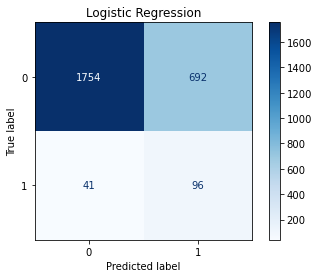


True Negatives: 1754
False Positives: 692
False Negatives: 41
True Positives: 96

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2446
           1       0.12      0.70      0.21       137

    accuracy                           0.72      2583
   macro avg       0.55      0.71      0.52      2583
weighted avg       0.93      0.72      0.79      2583



In [50]:
# Run the model - Logistic Regression

log_reg = run_model('lr', 'Logistic Regression')

#### 4.3.2 Random Forest Classifier

**Random Forests** is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree. Random Forests reduces overfitting in decision trees and helps to improve the accuracy. Also, it is flexible to both classification and regression problems and works well with both categorical and continuous values. 

The major limitation of Random Forests is it requires much computational power as well as resources as it builds numerous trees to combine their outputs. It also requires much time for training as it combines a lot of decision trees to determine the class. Last but not least, due to the ensemble of decision trees, it suffers interpretability and fails to determine the significance of each variable.

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
RandomForestClassifier(random_state=42),0.9993,0.7974,0.1457,0.9113,0.2701,0.1893


------------------------------------------------------

Confusion Matrix


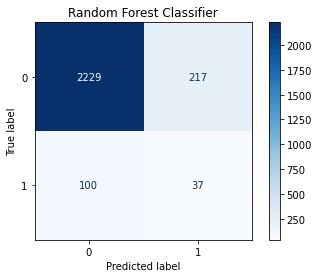


True Negatives: 2229
False Positives: 217
False Negatives: 100
True Positives: 37

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2446
           1       0.15      0.27      0.19       137

    accuracy                           0.88      2583
   macro avg       0.55      0.59      0.56      2583
weighted avg       0.91      0.88      0.89      2583



In [51]:
# Run the model - Random Forest Classifier

rf = run_model('rf', 'Random Forest Classifier')

#### 4.3.3 Extreme Gradient Boosting Classifier

**Extreme Gradient Boosting Classifier** is a decision-tree-based ensemble machine learning algorithm which designed for speed and performance. It is a highly optimized framework for gradient boosting, an algorithm that iteratively combines the predictions of several weak learners such as decision trees to produce a much stronger and more robust model. Extreme Gradient Boosting Classifier is highly flexible and it uses the power of parallel processing. Also, it is faster than Gradient Boosting and supports regularization.

The major limitation of Extreme Gradient Boosting Classifier is unable to extrapolate target values beyond the limits of the training data when making predictions due to the method with which tree-based models partition the input space of any given problem. 

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', use_label_encoder=False, validate_parameters=1, verbosity=None)",0.9975,0.827,0.2195,0.9477,0.2628,0.2392


------------------------------------------------------

Confusion Matrix


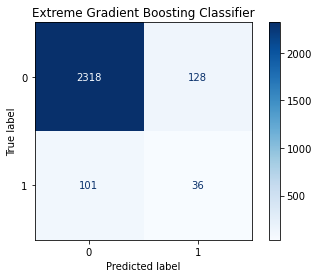


True Negatives: 2318
False Positives: 128
False Negatives: 101
True Positives: 36

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2446
           1       0.22      0.26      0.24       137

    accuracy                           0.91      2583
   macro avg       0.59      0.61      0.60      2583
weighted avg       0.92      0.91      0.92      2583



In [52]:
# Run the model - Extreme Gradient Boosting Classifier

xgb = run_model('xgb', 'Extreme Gradient Boosting Classifier')

#### 4.3.4 AdaBoost Classifier

**AdaBoost Classifier** is one of ensemble boosting classifier which combines multiple classifiers to increase the accuracy of classifiers. AdaBoost Classifier is an iterative ensemble method and it builds a strong classifier by combining multiple poorly performing classifiers so that we will get high accuracy strong classifier. The basic concept behind AdaBoost Classifier is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. 

The major limitation of AdaBoost Classifier is that it needs a quality dataset. Noisy data and outliers have to be avoided before adopting an AdaBoost Classifier algorithm. Also, AdaBoost Classifier has also been proven to be slower than Extreme Gradient Boosting Classifier. Computationally expensive for large datasets.

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
AdaBoostClassifier(random_state=42),0.8963,0.8098,0.1351,0.7592,0.6715,0.2249


------------------------------------------------------

Confusion Matrix


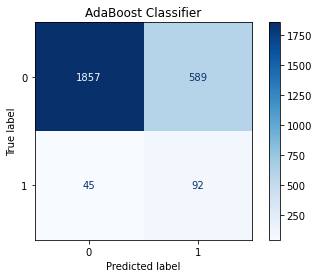


True Negatives: 1857
False Positives: 589
False Negatives: 45
True Positives: 92

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      2446
           1       0.14      0.67      0.22       137

    accuracy                           0.75      2583
   macro avg       0.56      0.72      0.54      2583
weighted avg       0.93      0.75      0.82      2583



In [53]:
# Run the model - AdaBoost Classifier

ada = run_model('ada', 'AdaBoost Classifier')

In [54]:
# Print the summary of modelling without hyperparameter tuning

summary

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"LogisticRegression(max_iter=5000, random_state=42, solver='saga')",0.8296,0.7446,0.1218,0.7171,0.7007,0.2076
RandomForestClassifier(random_state=42),0.9993,0.7974,0.1457,0.9113,0.2701,0.1893
"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', use_label_encoder=False, validate_parameters=1, verbosity=None)",0.9975,0.827,0.2195,0.9477,0.2628,0.2392
AdaBoostClassifier(random_state=42),0.8963,0.8098,0.1351,0.7592,0.6715,0.2249


In [55]:
init_dict = {
    log_reg: 'Logistic Regression',
    rf : 'Random Forest Classifier',
    xgb : 'Extreme Gradient Boosting Classifier',
    ada : 'AdaBoost Classifier'
}

In [56]:
# Plot AUC-ROC Curve

def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = RocCurveDisplay.from_estimator(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

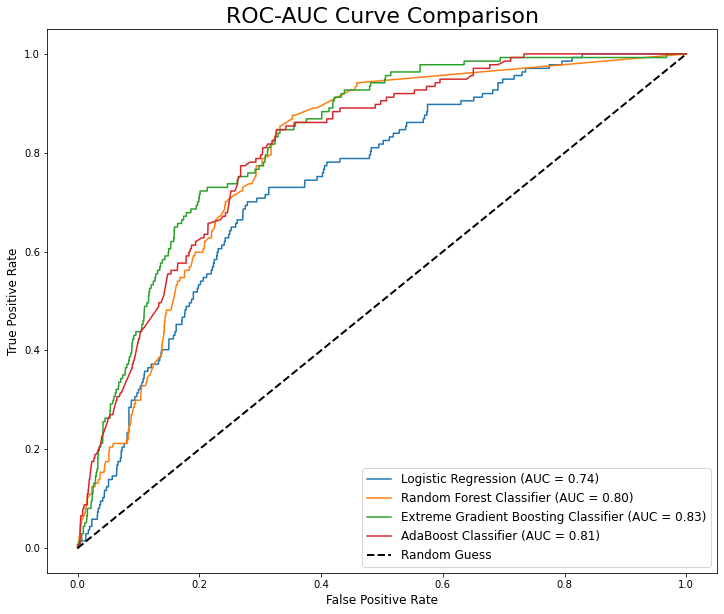

In [57]:
roc_curve_plotter(init_dict)

<b>Observation<b/> : 
    
1. Based on the above summary table, all the model are overfit, especially Random Forest Classifier and Extreme Gradient Boosting Classifier.
2. However, Random Forest Classifier, Extreme Gradient Boosting Classifier and AdaBoost Classifier models consider performing better in terms of AUC with Extreme Gradient Boosting Classifier model had the highest score. Indicating that it is a good model at predicting the classes correctly. It is still acceptable.
3. Logistic Regression and AdaBoost has the highest recall score, which represents the fraction of retrieved relevant instances among all relevant instances. In other words, it measures the proportion of positives that are correctly identified. Furthermore, AdaBoost model has the lowest number of False Negatives (i.e. predicting that West Nile Virus is not present when it is actually present), which is the most important as it is dangerous to tell the public that a certain location do not have presence of West Nile Virus when there is actually West Nile Virus present. As such, having a very small number of False Negatives is very important. 

### 4.4 Model Hyperparameter Tuning

In [58]:
# Logistic Regression
    
lr_params = {
     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[20, 30, 40],
}

In [59]:
# Random Forest Classifier

rf_params = {'rf__n_estimators': [20, 25, 30, 35, 40],
             'rf__max_depth': [20, 30, 40],
             'rf__min_samples_leaf': [2, 3],
            }

In [60]:
# XGB Classifier

xgb_params = {'xgb__learning_rate':[0.1],
              'xgb__subsample':[0.5],
              'xgb__colsample_bytree':[0.5],
              'xgb__max_depth':[3],
              'xgb__scale_pos_weight':[19],
              'xgb__n_estimators':[500],
              'xgb__reg_alpha':[0,1], 
              'xgb__reg_lambda':[1,3], 
              'xgb__gamma':[0.01,0.1]
              }

In [61]:
# AdaBoost Classifier

ada_params = {'ada__n_estimators': [100, 200],
              'ada__learning_rate': [0.9, 1.0, 2.0],
             }

#### 4.4.1 Logistic Regression

Fitting 10 folds for each of 3 candidates, totalling 30 fits


Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"LogisticRegression(max_iter=5000, random_state=42, solver='saga')",0.8306,0.7439,0.1234,0.7212,0.7007,0.2098


------------------------------------------------------
Best Hyperparameter


{'lr__C': 40}

------------------------------------------------------

Confusion Matrix


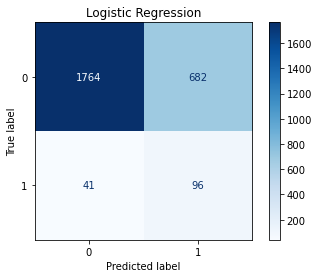


True Negatives: 1764
False Positives: 682
False Negatives: 41
True Positives: 96

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2446
           1       0.12      0.70      0.21       137

    accuracy                           0.72      2583
   macro avg       0.55      0.71      0.52      2583
weighted avg       0.93      0.72      0.80      2583



In [62]:
# Run the model - Logistic Regression

log_reg_gs = run_model('lr', 'Logistic Regression', model_params = lr_params, grid_search = True)

#### 4.4.2 Random Forest Classifier

Fitting 10 folds for each of 30 candidates, totalling 300 fits


Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
RandomForestClassifier(random_state=42),0.9893,0.8192,0.1614,0.8598,0.4818,0.2418


------------------------------------------------------
Best Hyperparameter


{'rf__max_depth': 30, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 40}

------------------------------------------------------

Confusion Matrix


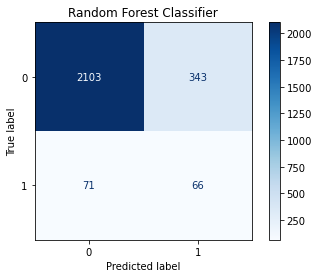


True Negatives: 2103
False Positives: 343
False Negatives: 71
True Positives: 66

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2446
           1       0.16      0.48      0.24       137

    accuracy                           0.84      2583
   macro avg       0.56      0.67      0.58      2583
weighted avg       0.92      0.84      0.87      2583



In [63]:
# Run the model - Random Forest Classifier

rf_gs = run_model('rf', 'Random Forest Classifier', model_params = rf_params, grid_search = True)

#### 4.4.3 Extreme Gradient Boosting Classifier

Fitting 10 folds for each of 8 candidates, totalling 80 fits


Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', use_label_encoder=False, validate_parameters=1, verbosity=None)",0.9814,0.806,0.1209,0.6791,0.7883,0.2097


------------------------------------------------------
Best Hyperparameter


{'xgb__colsample_bytree': 0.5,
 'xgb__gamma': 0.01,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 500,
 'xgb__reg_alpha': 1,
 'xgb__reg_lambda': 1,
 'xgb__scale_pos_weight': 19,
 'xgb__subsample': 0.5}

------------------------------------------------------

Confusion Matrix


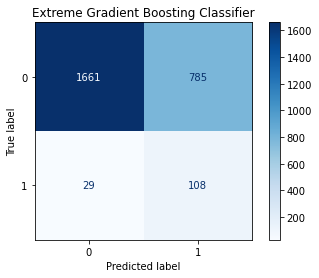


True Negatives: 1661
False Positives: 785
False Negatives: 29
True Positives: 108

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      2446
           1       0.12      0.79      0.21       137

    accuracy                           0.68      2583
   macro avg       0.55      0.73      0.51      2583
weighted avg       0.94      0.68      0.77      2583



In [64]:
# Run the model - Extreme Gradient Boosting Classifier

xgb_gs = run_model('xgb', 'Extreme Gradient Boosting Classifier', model_params = xgb_params, grid_search = True)

#### 4.4.4 AdaBoost Classifier

Fitting 10 folds for each of 6 candidates, totalling 60 fits


Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
AdaBoostClassifier(random_state=42),0.9345,0.8151,0.1493,0.7903,0.6569,0.2432


------------------------------------------------------
Best Hyperparameter


{'ada__learning_rate': 1.0, 'ada__n_estimators': 200}

------------------------------------------------------

Confusion Matrix


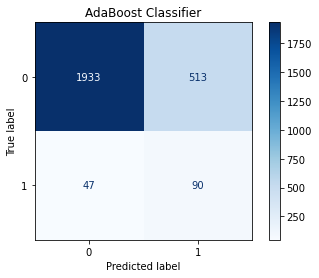


True Negatives: 1933
False Positives: 513
False Negatives: 47
True Positives: 90

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2446
           1       0.15      0.66      0.24       137

    accuracy                           0.78      2583
   macro avg       0.56      0.72      0.56      2583
weighted avg       0.93      0.78      0.84      2583



In [65]:
# Run the model - AdaBoost Classifier

ada_gs = run_model('ada', 'AdaBoost Classifier', model_params = ada_params, grid_search = True)

In [66]:
# Print the summary of modelling after hyperparameter tuning

summary_tuning

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"LogisticRegression(max_iter=5000, random_state=42, solver='saga')",0.8306,0.7439,0.1234,0.7212,0.7007,0.2098
RandomForestClassifier(random_state=42),0.9893,0.8192,0.1614,0.8598,0.4818,0.2418
"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', use_label_encoder=False, validate_parameters=1, verbosity=None)",0.9814,0.806,0.1209,0.6791,0.7883,0.2097
AdaBoostClassifier(random_state=42),0.9345,0.8151,0.1493,0.7903,0.6569,0.2432


In [67]:
gs_dict = {
    xgb_gs: 'Extreme Gradient Boosting Classifier',
    ada_gs: 'AdaBoost Classifier',
    rf_gs: 'Random Forest Clasifier',
    log_reg_gs: 'Logistic Regression'
}

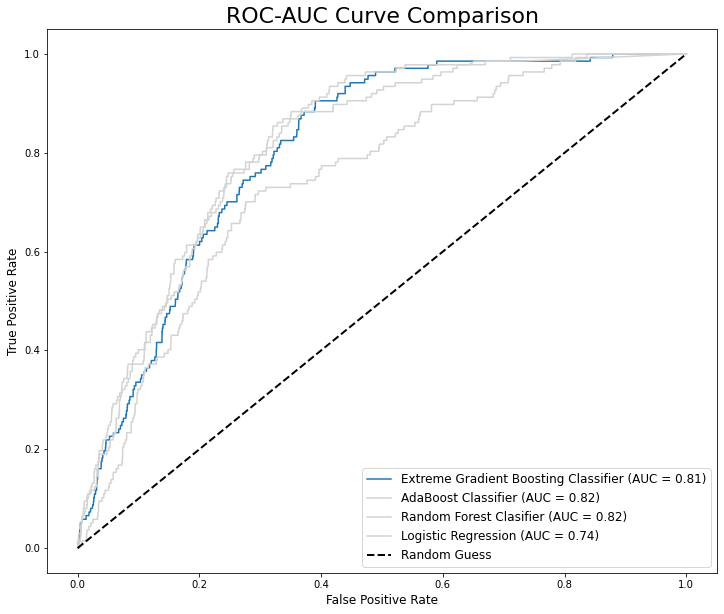

In [68]:
# Plot AUC-ROC Curve

roc_curve_plotter(gs_dict, plot_top=True)

<b>Observation<b/> : 
    
1. Based on the above summary table, after hyperparamter tuning all our model is still overfitting as indicated by the gap between test and train scores.
2. Based on AUC-ROC curve, Random Forest Classifier, Extreme Gradient Boosting Classifier and AdaBoost Classifier models are same! However, Extreme Gradient Boosting Classifier model outperforming most of the models with highest recall score. 
4. Thus, Extreme Gradient Boosting Classifier model is choose as our production model.

## 5. Model Production & Kaggle Submission

### 5.1 Coefficients

In [69]:
# Get the best pipeline of our production model - Extreme Gradient Boosting Classifier

xgb_gs.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, enable_categorical=False,
                               eval_metric='mlogloss', gamma=0.01, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=1, reg_lambda=1,
                               scale_pos_weight=19, subsample=0.5,
                               tree_method='exact', use_label_encoder=False,
                               validate

In [70]:
# Get the feature importance 

feature_imp = pd.DataFrame(xgb_gs.best_estimator_.steps[1][1].feature_importances_, index=X_train.columns, columns=['coef']).sort_values('coef', ascending=False)
feature_imp.head(15)

,coef
month,0.118537
year,0.069699
nighttime,0.056385
trap_T046,0.044914
rain,0.041591
species,0.038028
street_ W GRAND AVE,0.035441
species_dewpoint,0.033700
month_dewpoint,0.032980
nightime_dewpoint,0.031178


In [71]:
# Refit model on training data

final_train_model = xgb_gs.fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [72]:
pickle.dump(final_train_model, open("xgb_trained.pickle.dat", "wb"))

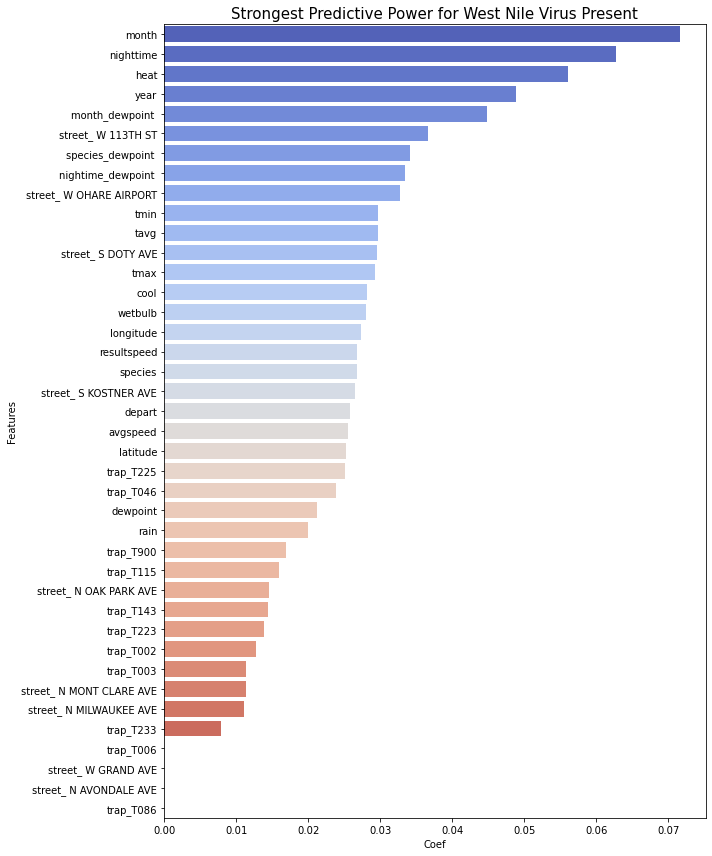

In [73]:
# Plot bar chart of top 15 words with strongest predictive power for both subreddit in our production model - Extreme Gradient Boosting Classifier

feature_imp = pd.DataFrame(xgb_gs.best_estimator_.steps[1][1].feature_importances_, index = X_train.columns, columns=['coef']).sort_values('coef', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data = feature_imp, y = feature_imp.index, x = 'coef', orient = 'h', palette='coolwarm')
plt.ylabel('Features')
plt.xlabel('Coef')
plt.title('Strongest Predictive Power for West Nile Virus Present', size = 15)
plt.savefig('./image/Strongest Predictive Power for West Nile Virus Present.png')
plt.tight_layout()

<b>Observation<b/> : 
    
1. Based on the above summary table, month, nighttime & heat temperature are the top 3 most important features in predicting if a West Nile Virus is present. Which is expected since warm and moist weather is a Mosquito's Friend especially Summer time.

### 5.2 Predictions

In [77]:
pred_proba = final_train_model.predict_proba(final_test_df)

In [78]:
pred_proba_t = [i[1] for i in pred_proba]

In [86]:
submission = pd.DataFrame()
submission['id'] = test_id
submission['wnvpresent'] = pred_proba_t


#View submission
submission.head()

,id,wnvpresent
0,1,0.012196
1,2,0.001571
2,3,0.012196
3,4,0.000173
4,5,0.000173


In [85]:
# Create csv for submission

submission.to_csv('./data/kaggle.csv', index = False)

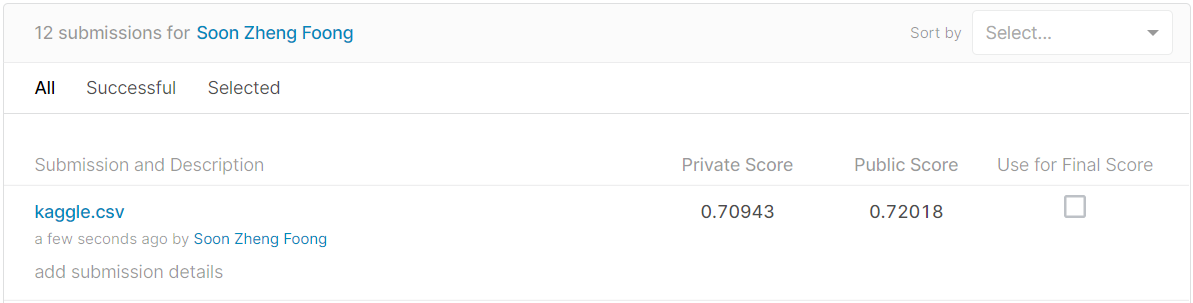